# Reinforcement Learning

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import os
import gym

## Introduction to OpenAI gym

In this notebook we will be using OpenAI gym, a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning agents to interact with.

Let's list all the available environments:

In [2]:
gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

The Cart-Pole is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

In [3]:
env = gym.make('CartPole-v1')

Let's initialize the environment by calling is reset() method. This returns an observation:

In [4]:
obs = env.reset()

In [5]:
obs

array([ 4.42508534e-02,  6.02563392e-03, -3.95384759e-05,  4.16110945e-02])

In [6]:
env.render()

True

In [7]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [8]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

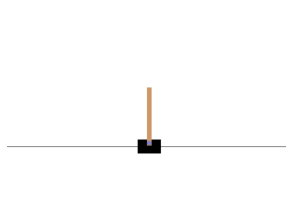

In [9]:
plot_environment(env)
plt.show()

Let’s ask the environment what actions are possible:

In [10]:
env.action_space

Discrete(2)

In [11]:
action = 0  # accelerate left

In [12]:
obs, reward, done, info = env.step(action)

In [13]:
obs

array([ 0.04437137, -0.18909575,  0.00079268,  0.33428155])

In [14]:
reward

1.0

In [15]:
done

False

In [16]:
info

{}

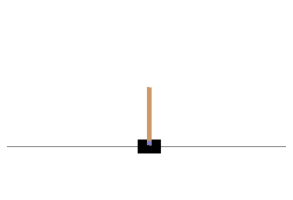

In [19]:
plot_environment(env)
plt.show()

In [20]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [21]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.888, 8.855250194093898, 24.0, 64.0)

In [22]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [24]:
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rc('animation', html='jshtml')

In [25]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [26]:
plot_animation(frames)